### Packages

In [1]:
# Essentials
import pandas as pd

# ML Modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn import set_config; set_config(display='diagram')

import pickle

# For preprosessing
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# Graphs
import matplotlib.pyplot as plt

### Data Import

In [2]:
file = '/home/nawar82/code/nawar82/ResearchTopicsRanker/raw_data/abstracts_thyrotropin-OR-TSH_2024-03-21_10-18-44.csv'

data = pd.read_csv(file)
data.head()

,PMID,Abstract
0,38506164,The effectiveness of levothyroxine (LT4) in re...
1,38464371,Diabetes and thyroiditis are closely related. ...
2,38449627,The thyroid represents the most prevalent form...
3,38296053,Evidence suggests that hypothyroidism may be a...
4,38287682,The aim of this study was to determine the imp...


In [3]:
data.shape

(640, 2)

### Preprocessing

#### preparing Acedemic and Medical Stopwords (RedundantWords.csv)

In [4]:
rw = '/home/nawar82/code/nawar82/ResearchTopicsRanker/raw_data/RedundantWords.csv'

sw = pd.read_csv(rw, header=0, names=['academic_stopwords'])
sw.head()

,academic_stopwords
0,Academic
1,Achievement
2,Advisor
3,Analysis
4,Argument


In [5]:
academic_Stopwords = sw['academic_stopwords'].tolist()
len(academic_Stopwords)

92

In [6]:
def preprocessing(sentence):

    # remove whitespace
    sentence = sentence.strip()

    # lowercase characters
    sentence = sentence.lower()

    # remove numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # remove punctuation
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')

    # remove stop_words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # remove academic and medical stop_words
    filtered_words = [word for word in filtered_words if word.lower() not in academic_Stopwords]
    sentence = ' '.join(filtered_words)

    # tokenize and lemmatize
    words = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs
    lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in lemmatized_words]  # Lemmatize nouns

    return ' '.join(lemmatized_words)

In [7]:
data['clean_text'] = data['Abstract'].apply(preprocessing)
data

,PMID,Abstract,clean_text
0,38506164,The effectiveness of levothyroxine (LT4) in re...,effectiveness levothyroxine lt restore thyroid...
1,38464371,Diabetes and thyroiditis are closely related. ...,diabetes thyroiditis closely relate occur comb...
2,38449627,The thyroid represents the most prevalent form...,thyroid represent prevalent form head neck end...
3,38296053,Evidence suggests that hypothyroidism may be a...,evidence suggest hypothyroidism may associate ...
4,38287682,The aim of this study was to determine the imp...,aim study determine impact covid pandemic test...
...,...,...,...
635,6127000,"A population sample of women in Göteborg, Swed...",population sample woman göteborg sweden study ...
636,7288274,This paper presents the results of various met...,paper present result various metabolic investi...
637,6794011,Low concentrations of thyrotropin-releasing ho...,low concentration thyrotropinreleasing hormone...
638,469388,The aetiology of Menière's disease is unknown ...,aetiology menières disease unknown recent year...


### Functions

In [8]:
def lda_model_fit(n_components, max_iter, vectorized_documents):
    lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = max_iter)

    # Fit the LDA on the vectorized documents
    lda_model.fit(vectorized_documents)

    return lda_model

In [9]:
def topics_list(model, vectorizer, top_words):
    topics = []
    for idx, topic in enumerate(model.components_):
        # print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_words - 1:-1]]
        # print(topic)
        topics.append(topic)
    return topics

In [10]:
def print_topics(model, vectorizer):
    topics = []
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-10 - 1:-1]]
        print(topic)
        topics.append(topic)
    return topics

In [11]:
def graph_topics(topics):
    # Calculating the number of rows and columns
    num_sets = len(topics)
    num_cols = 2  # Number of columns you want
    num_rows = -(-num_sets // num_cols)  # Ceiling division to ensure enough rows

    # Plotting each data set
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    for i, data in enumerate(topics):
        row = i // num_cols
        col = i % num_cols
        labels = [item[0] for item in data]
        values = [item[1] for item in data]
        axs[row, col].barh(labels, values, color='skyblue')
        axs[row, col].set_ylabel('Keywords')
        axs[row, col].set_title('Topic {}'.format(i))
        axs[row, col].invert_yaxis()

    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

### Run LDA to see the topics

In [12]:
vectorizer = TfidfVectorizer(max_df = 0.98, ngram_range=(2,5))

vectorized_documents = vectorizer.fit_transform(data['clean_text'])

In [13]:
vectorized_documents.shape

(640, 339671)

In [14]:
# Instantiate the LDA
n_components = 10
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 500)

# Fit the LDA on the vectorized documents
lda_model.fit(vectorized_documents)

LatentDirichletAllocation(max_iter=500)

In [15]:
document_topic_mixture = pd.DataFrame(lda_model.transform(vectorized_documents),
                                    columns = [f"topic_{i}" for i in range(1, n_components+1)],
                                    index = data['PMID'])
document_topic_mixture

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
PMID,,,,,,,,,,
38506164,0.003695,0.003695,0.003695,0.003695,0.003695,0.003695,0.966748,0.003695,0.003695,0.003695
38464371,0.003581,0.967774,0.003580,0.003581,0.003581,0.003580,0.003581,0.003580,0.003581,0.003581
38449627,0.004274,0.004274,0.004274,0.004274,0.004274,0.004274,0.004274,0.961535,0.004274,0.004274
38296053,0.003985,0.003986,0.003985,0.003986,0.964130,0.003986,0.003986,0.003986,0.003985,0.003986
38287682,0.004451,0.004451,0.004451,0.004451,0.004451,0.004451,0.004451,0.004451,0.959939,0.004451
...,...,...,...,...,...,...,...,...,...,...
6127000,0.952500,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278
7288274,0.005189,0.005189,0.005189,0.005189,0.953302,0.005189,0.005189,0.005189,0.005189,0.005189
6794011,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.945911


In [16]:
topic_word_mixture = pd.DataFrame(
    lda_model.components_,
    columns = vectorizer.get_feature_names_out(),
    index = document_topic_mixture.columns
)
topic_word_mixture

,aa addition,aa addition fatty,aa addition fatty acid,aa addition fatty acid culture,aa adrenic,aa adrenic acid,aa adrenic acid deficit,aa adrenic acid deficit overcome,aa adrenic acid pgl,aa adrenic acid pgl compensate,...,μuml patient overt thyroid,μuml patient overt thyroid dysfunction,μuml subclinical,μuml subclinical hypothyroidism,μuml subclinical hypothyroidism thyroidstimulating,μuml subclinical hypothyroidism thyroidstimulating hormone,μuml synergized,μuml synergized increase,μuml synergized increase level,μuml synergized increase level triglyceride
topic_1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_3,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_5,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_6,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_7,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.138741,0.138741,0.138741,0.138741,0.138741,0.138741,0.100000,0.100000,0.100000,0.100000
topic_8,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
topic_9,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.138439,0.138439,0.138439,0.138439
topic_10,0.133409,0.133409,0.133409,0.133409,0.166818,0.166818,0.133409,0.133409,0.133409,0.133409,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [17]:
topics = topics_list(lda_model, vectorizer, 5)

In [18]:
type(topics)

list

In [19]:
type(topics[0])

list

In [20]:
type(topics[0][0])

tuple

In [21]:
topics[1][0]

('thyroid hormone', 0.7103009017240166)

In [22]:
len(topics)

10

In [23]:
topics

[[('tsh level', 0.6135469917392701),
  ('hepatic dysfunction', 0.4544424548215257),
  ('fetuina level', 0.4478956660219846),
  ('control group', 0.4422368808199786),
  ('risk factor', 0.42359752889363533)],
 [('thyroid hormone', 0.7103009017240166),
  ('tsh level', 0.6997937559250356),
  ('thyroid function', 0.666418050617312),
  ('lipoprotein cholesterol', 0.5945403447093688),
  ('total cholesterol', 0.5504189496640396)],
 [('thyroid hormone', 0.7624321033852091),
  ('thyroid function', 0.6929223519823788),
  ('subclinical hypothyroidism', 0.5758813619560454),
  ('tsh level', 0.5209167738102114),
  ('risk factor', 0.46967076635658744)],
 [('risk factor', 0.5514223634582156),
  ('per cent', 0.5437971224401149),
  ('metabolic syndrome', 0.4865518368112959),
  ('leydig cell', 0.48382474242963713),
  ('blood pressure', 0.4816261784621887)],
 [('tsh level', 0.7943926673690854),
  ('subclinical hypothyroidism', 0.5731958146773766),
  ('overt hypothyroidism', 0.5350020150316971),
  ('thyroid

In [24]:
lda_model.components_.shape

(10, 339671)

In [25]:
vectorizer.get_feature_names_out().shape

(339671,)

In [26]:
lda_model.components_[1].sum()

35722.321110479475

### Visualization

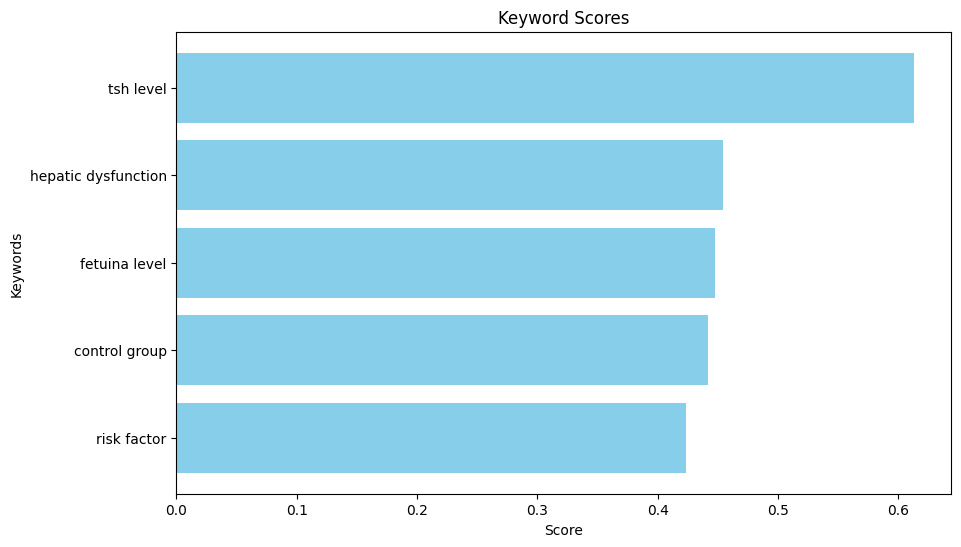

In [27]:
data = topics[0]

labels = [item[0] for item in data]
values = [item[1] for item in data]

# Creating bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Keywords')
plt.title('Keyword Scores')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

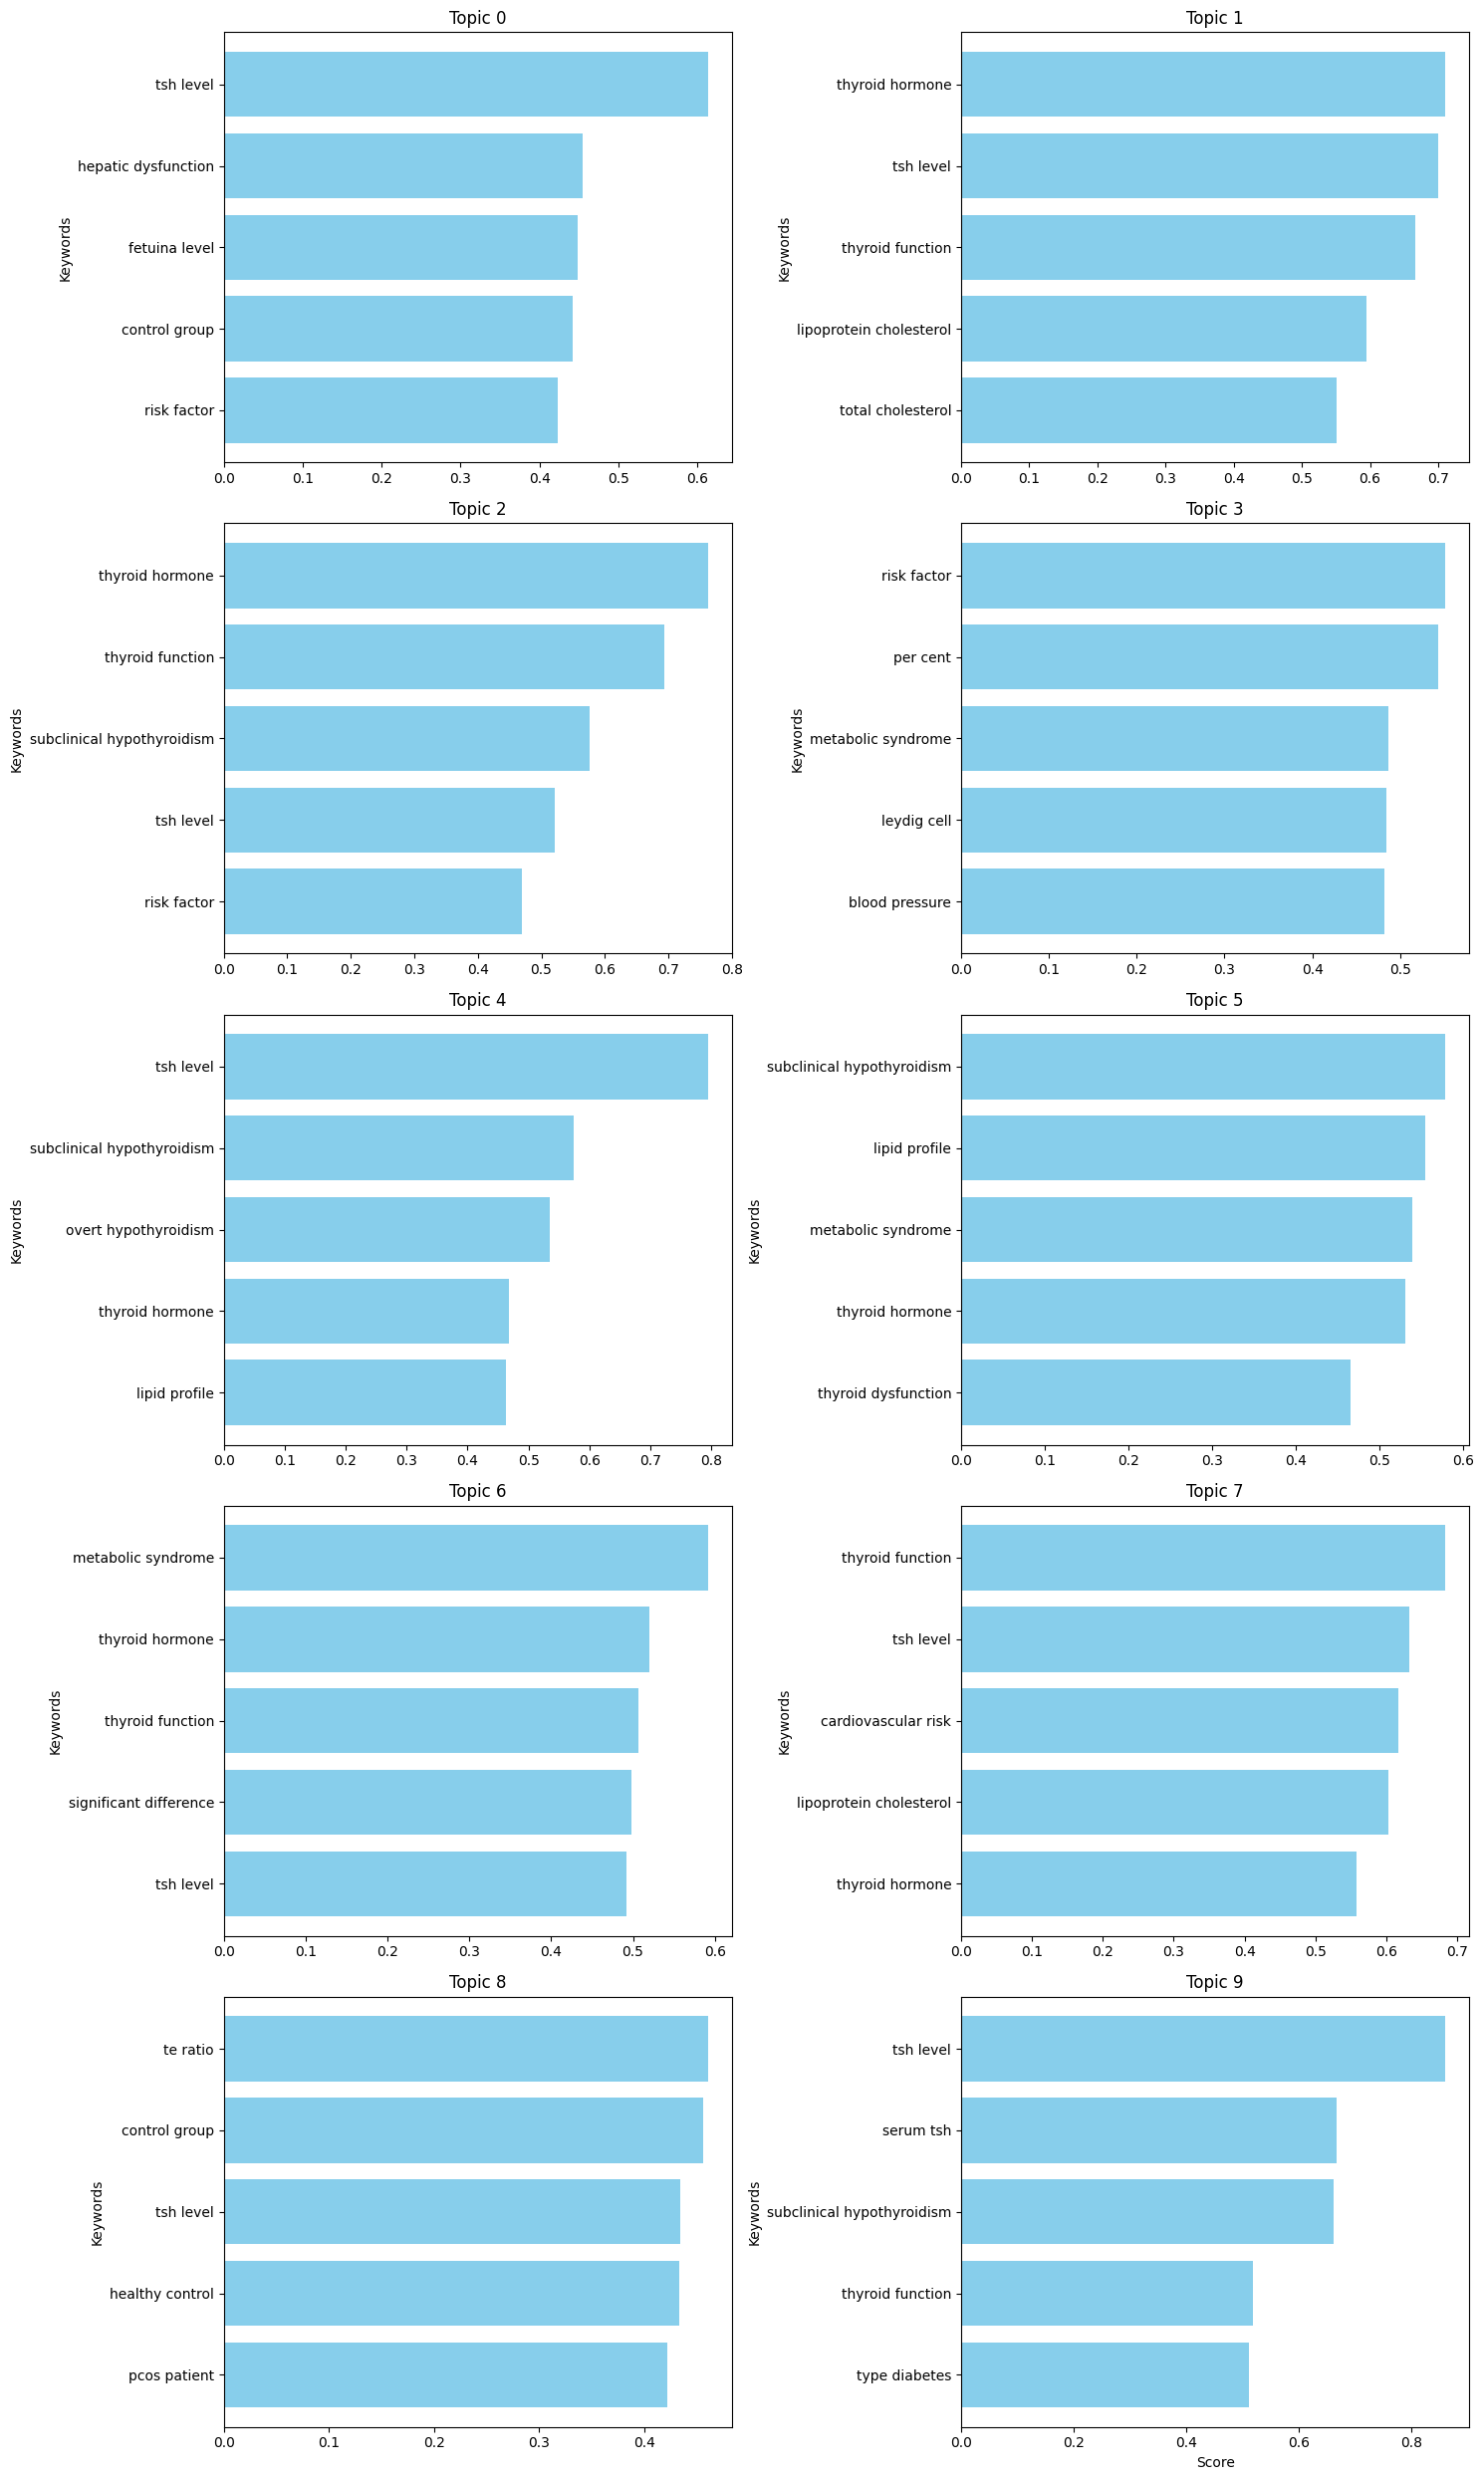

In [28]:
graph_topics(topics)

## distributing the documents into their topics

In [29]:
document_topic_mixture['Dominant_topic'] = document_topic_mixture.idxmax(axis=1)

In [30]:
document_topic_mixture

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,Dominant_topic
PMID,,,,,,,,,,,
38506164,0.003695,0.003695,0.003695,0.003695,0.003695,0.003695,0.966748,0.003695,0.003695,0.003695,topic_7
38464371,0.003581,0.967774,0.003580,0.003581,0.003581,0.003580,0.003581,0.003580,0.003581,0.003581,topic_2
38449627,0.004274,0.004274,0.004274,0.004274,0.004274,0.004274,0.004274,0.961535,0.004274,0.004274,topic_8
38296053,0.003985,0.003986,0.003985,0.003986,0.964130,0.003986,0.003986,0.003986,0.003985,0.003986,topic_5
38287682,0.004451,0.004451,0.004451,0.004451,0.004451,0.004451,0.004451,0.004451,0.959939,0.004451,topic_9
...,...,...,...,...,...,...,...,...,...,...,...
6127000,0.952500,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,topic_1
7288274,0.005189,0.005189,0.005189,0.005189,0.953302,0.005189,0.005189,0.005189,0.005189,0.005189,topic_5
6794011,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.006010,0.945911,topic_10


## Plotting the dominant topics distribution

In [31]:
# Count how many documents have each topic as the most dominant
topic_counts = document_topic_mixture['Dominant_topic'].value_counts()
topic_counts

Dominant_topic
topic_2     74
topic_8     74
topic_3     64
topic_10    64
topic_4     64
topic_7     63
topic_6     62
topic_9     60
topic_5     58
topic_1     57
Name: count, dtype: int64

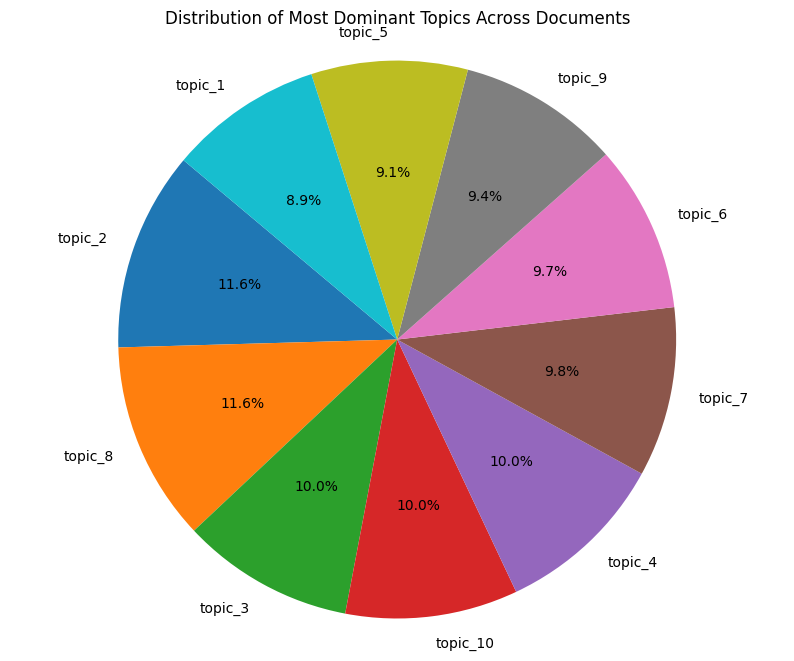

In [32]:

# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Most Dominant Topics Across Documents')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## pyLDAvis


In [1]:
import pyLDAvis
import numpy as np

In [2]:
# lda_model.components_ has shape [n_topics, n_features]
topic_term_distributions = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]

/home/nawar82/.pyenv/versions/3.10.6/envs/ResearchTopicsRanker/lib/python3.10/site-packages/astroid/node_classes.py:94: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  warnings.warn(


NameError: name 'lda_model' is not defined